Connected to non_local_detector2 (Python 3.12.7)

# A Tutorial on Parameterizing Space

Our goal is often to understand how neural activity relates to the animal's
position, or to decode the animal's position from neural activity. This requires
a precise, discretized model of the experimental environment. This tutorial
demonstrates how to create, manipulate, and analyze such environmental models.

Key Workflow & Features Covered:
---------------------------------
1.  **Initial Data**: Starting with raw animal position data (e.g., from video tracking).
2.  **Coordinate Calibration**: Converting pixel coordinates to physical units (cm).
3.  **Defining Environments from Position Data**: Creating a `RegularGrid` environment based on where the animal went.
4.  **Core Environment Operations**:
    * Mapping between continuous positions and discrete bins (`bin_at`, `bin_center_of`).
    * Understanding spatial properties: `bin_sizes`, `active_mask`, `dimension_ranges`.
    * Analyzing connectivity: `neighbors`, `distance_between`, `shortest_path`.
5.  **Defining Maze-Relevant Regions**: Segmenting the environment into meaningful parts like arms, choice points, and reward wells.
6.  **Alternative Ways to Define Environments**:
    * From an image mask of the maze.
    * Using `GraphLayout` for linear tracks or abstract 1D spaces (like head direction).
    * Using `Polygon` or `TriangularMesh` for complex boundaries.
    * Briefly, other grid types like `HexagonalLayout` and `MaskedGridLayout`.
7.  **Handling Complex Mazes & Multiple Sessions**:
    * `CompositeEnvironment`: Modeling mazes with distinct parts (e.g., a 2D central area plus linear arms).
    * `Alignment`: Mapping data (e.g., place fields) between slightly different environments or recording sessions.
8.  **API Discovery**: Finding available layouts and their parameters.
9.  **Saving and Loading Environments**: Persisting your environment configurations for future use.

Let's begin our journey of parameterizing space! 🚀
Helper functions and imports

In [1]:
import os
import tempfile

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import multivariate_normal
from shapely.geometry import Point as ShapelyPoint
from shapely.geometry import Polygon
from track_linearization import make_track_graph

# Core imports from the environment package
from non_local_detector.environment import get_layout_parameters, list_available_layouts
from non_local_detector.environment.alignment import (
    apply_similarity_transform,
    get_2d_rotation_matrix,
    map_probabilities_to_nearest_target_bin,
)
from non_local_detector.environment.composite import CompositeEnvironment
from non_local_detector.environment.environment import Environment
from non_local_detector.environment.regions import plot_regions

# Consistent styling for raw data points in plots
RAW_DATA_STYLE = {"s": 5, "c": "lightcoral", "alpha": 0.5, "label": "Animal Positions"}
MAZE_BOUNDARY_STYLE = {"color": "darkblue", "linewidth": 1.5, "label": "Maze Boundary"}
REWARD_WELL_STYLE = {
    "s": 150,
    "marker": "*",
    "alpha": 0.9,
    "zorder": 10,
}
ARM_REGION_BASE_STYLE = {"alpha": 0.3, "linewidth": 1.0, "edgecolor": "gray"}

/Users/edeno/Documents/GitHub/non_local_detector/src/non_local_detector/likelihoods/clusterless_kde.py:54: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


 ## Part 1: From Raw Tracking Data to a Usable Spatial Representation

 Imagine we've just run an experiment. We have video tracking data of a rat exploring a U-shaped maze.
 This data is likely in **pixel coordinates** from the camera. Our first step is to convert it to
 **physical units (cm)** and then create a basic spatial model.

 ### 1.1 Simulate Raw Position Data (Pixels)
 For this tutorial, we'll simulate some noisy data. In a real scenario, this would come from your tracking software.
 Let's assume a 640x480 pixel video frame. Our U-shaped maze path in *pixel space*:
 (50,430) -> (50,50) -> (350,50) -> (350,430). (Origin: top-left for raw pixels)

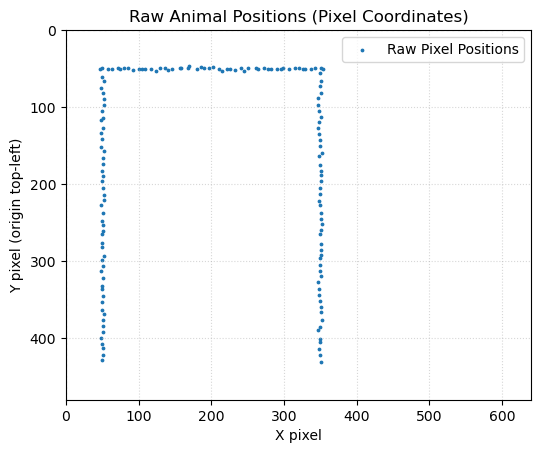

In [2]:
# Path in PIXEL coordinates (origin top-left)
px_path_y_coords = np.linspace(
    50, 430, 50
)  # Y goes from 50 (top) to 430 (bottom) for first segment
px_path_x_coords = np.linspace(50, 350, 50)  # X for horizontal segment

seg1_px = np.stack(
    (np.ones_like(px_path_y_coords) * 50, px_path_y_coords[::-1]), axis=1
)  # (50, 430) -> (50, 50)
seg2_px = np.stack(
    (px_path_x_coords, np.ones_like(px_path_x_coords) * 50), axis=1
)  # (50, 50) -> (350, 50)
seg3_px = np.stack(
    (np.ones_like(px_path_y_coords) * 350, px_path_y_coords), axis=1
)  # (350, 50) -> (350, 430)

raw_pixel_positions = np.vstack([seg1_px, seg2_px, seg3_px])
raw_pixel_positions += multivariate_normal(mean=[0, 0], cov=2.0).rvs(
    size=raw_pixel_positions.shape[0]
)  # Pixel noise

plt.figure(figsize=(6, 4.8))  # Aspect ratio of 640x480
plt.scatter(
    raw_pixel_positions[:, 0],
    raw_pixel_positions[:, 1],
    s=3,
    label="Raw Pixel Positions",
)
plt.title("Raw Animal Positions (Pixel Coordinates)")
plt.xlabel("X pixel")
plt.ylabel("Y pixel (origin top-left)")
plt.xlim(0, 640)
plt.ylim(480, 0)  # Invert Y axis to match typical image coordinates
plt.axhline(0, color="gray", linestyle=":")
plt.axvline(0, color="gray", linestyle=":")
plt.legend()
plt.grid(True, linestyle=":", alpha=0.5)
plt.show()

 ### 1.2 Coordinate Calibration: Pixels to Centimeters
 We need to work in common world coordinates and translate to physical units (like cm).
 So we need to calibrate the pixel coordinates to a physical scale.
 Let's say the horizontal segment (300 pixels wide: from 50px to 350px) is 60 cm long.
 So, `px_per_cm = 300px / 60cm = 5 px/cm`.
 Let's also define that the point (50px, 50px) in *our pixel data's coordinate system* (top-left origin)
 should become our physical `(0,0) cm` point in a *bottom-left origin* system.


--- Coordinate Calibration ---
Calibration: 5.0 px/cm, physical origin at raw pixel (50,50)
Example raw pixel point [ 49.86928106 428.5355846 ] converted to cm: [ 9.97385621 10.29288308]
Example raw pixel point [46.72911624 50.47764294] (start of seg2) converted to cm: [ 9.34582325 85.90447141]
Example raw pixel point [350.44054565 430.55388108] converted to cm: [70.08810913  9.88922378]


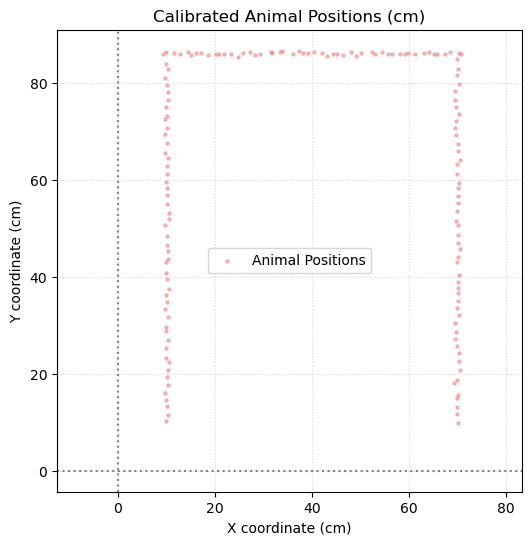

In [3]:
# Calibration parameters
frame_height_px = 480.0  # For y-flip
frame_width_px = 640.0  # Width of the video frame in pixels
px_per_cm_calibration = 5.0
# The physical (0,0) cm origin corresponds to pixel (50, 50) in raw top-left pixel coords.

# We use `non_local_detector.transforms.convert_to_cm` which combines y-flip and scaling.
# `convert_to_cm` takes `cm_per_px`. If 5 px = 1 cm, then 1 px = 1/5 cm = 0.2 cm.
from non_local_detector.environment.transforms import convert_to_cm

cm_per_px_calibration = 1.0 / px_per_cm_calibration  # 0.2 cm per pixel

# `convert_to_cm` assumes the scaling is applied around a (0,0) of the *y-flipped* frame.
# If (50,50)px_raw is (0,0)cm_physical_bottom_left:
# 1. Y-flip: (50, 50)px_raw -> x=50, y_flipped = 480-50 = 430. So (50, 430) in bottom-left pixel coords.
# 2. Scale this (50,430) in px_bottom_left to get (0,0)cm.
#    x_cm = (x_px_bottom_left - offset_x_px_bottom_left) * cm_per_px
#    y_cm = (y_px_bottom_left - offset_y_px_bottom_left) * cm_per_px
#    So, (offset_x_px_bottom_left, offset_y_px_bottom_left) = (50, 430)
# `convert_to_cm` will apply this transformation to all points.
position_data_cm = convert_to_cm(
    raw_pixel_positions,
    cm_per_px=cm_per_px_calibration,
    frame_size_px=(frame_width_px, frame_height_px),
)

print(f"\n--- Coordinate Calibration ---")
print(
    f"Calibration: {px_per_cm_calibration} px/cm, physical origin at raw pixel (50,50)"
)
print(
    f"Example raw pixel point {raw_pixel_positions[0]} converted to cm: {position_data_cm[0]}"
)
print(
    f"Example raw pixel point {raw_pixel_positions[50]} (start of seg2) converted to cm: {position_data_cm[50]}"
)  # (50,50)px -> (0,0)cm
print(
    f"Example raw pixel point {raw_pixel_positions[-1]} converted to cm: {position_data_cm[-1]}"
)

# Plot calibrated (cm) data
plt.figure(figsize=(6, 6))
plt.scatter(position_data_cm[:, 0], position_data_cm[:, 1], **RAW_DATA_STYLE)
plt.title("Calibrated Animal Positions (cm)")
plt.xlabel("X coordinate (cm)")
plt.ylabel("Y coordinate (cm)")
plt.axhline(0, color="gray", linestyle=":")
plt.axvline(0, color="gray", linestyle=":")
plt.axis("equal")
plt.grid(True, linestyle=":", alpha=0.5)
plt.legend()
plt.show()

 ### 1.3 Creating a `RegularGrid` Environment from Calibrated Position Samples
 Now that we have positions in cm, we can create our first `Environment`.
 `Environment.from_samples` is a convenient way to do this when you have a cloud of position samples.
 It will infer the spatial extent and create active bins where the animal visited.

 We can also easily visualize the environment using `Environment.plot()`.


--- Main RegularGrid Environment (from cm data) ---
Environment Name: MainMaze_Grid
Layout Type: RegularGrid
Number of active bins: 75
Number of dimensions: 2
Spatial extent (dimension_ranges): ((np.float64(7.84582324737036), np.float64(72.24447729413268)), (np.float64(8.38922378357249), np.float64(88.06376296009313)))


<Figure size 600x600 with 0 Axes>

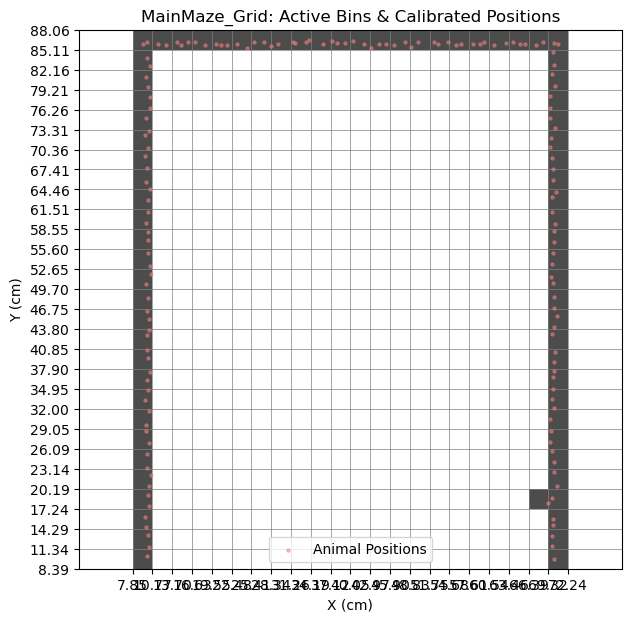

In [4]:
grid_env_main = Environment.from_samples(
    data_samples=position_data_cm,
    name="MainMaze_Grid",
    layout_kind="RegularGrid",  # Default, but good to be explicit
    bin_size=3.0,  # Each grid cell will be 3cm x 3cm
    infer_active_bins=True,  # Default, keeps only bins with data
    bin_count_threshold=0,  # Bins with samples are active.
)

# Because bin_count_threshold=0, even a bin with a single sample is considered active.
# If you want to ignore bins with very few visits, you could set bin_count_threshold=5 (for example).

print("\n--- Main RegularGrid Environment (from cm data) ---")
print(f"Environment Name: {grid_env_main.name}")
print(f"Layout Type: {grid_env_main.layout_type}")
print(f"Number of active bins: {grid_env_main.n_bins}")
print(f"Number of dimensions: {grid_env_main.n_dims}")
print(f"Spatial extent (dimension_ranges): {grid_env_main.dimension_ranges}")

# Plot this environment
plt.figure(figsize=(6, 6))
ax = grid_env_main.plot(show_connectivity=False)  # Shows pcolormesh of active bins
ax.scatter(position_data_cm[:, 0], position_data_cm[:, 1], **RAW_DATA_STYLE, zorder=5)
ax.set_title(f"{grid_env_main.name}: Active Bins & Calibrated Positions")
plt.xlabel("X (cm)")
plt.ylabel("Y (cm)")
plt.axis("equal")
plt.legend()
plt.show()

 ## Part 2: Interacting with the Discretized Environment
 Once the environment is defined, we can query it. This is crucial for relating continuous data (like animal position or decoded estimates) to the discrete model used by, for example, a Bayesian decoder.


Key attributes:
- **`bin_centers`**: The centers of the active discrete bins in physical units.
 - **`bin_sizes`**: The size of each bin in physical units.

`active` here means the bins that define the environment. In this case, since we used `from_samples`, it will only include bins where the animal was active (visited).


In [5]:
grid_env_main.bin_centers # Get the centers of the active bins

array([[ 9.30942902,  9.86467821],
       [ 9.30942902, 12.81558707],
       [ 9.30942902, 15.76649593],
       [ 9.30942902, 18.71740479],
       [ 9.30942902, 21.66831365],
       [ 9.30942902, 24.6192225 ],
       [ 9.30942902, 27.57013136],
       [ 9.30942902, 30.52104022],
       [ 9.30942902, 33.47194908],
       [ 9.30942902, 36.42285794],
       [ 9.30942902, 39.3737668 ],
       [ 9.30942902, 42.32467566],
       [ 9.30942902, 45.27558451],
       [ 9.30942902, 48.22649337],
       [ 9.30942902, 51.17740223],
       [ 9.30942902, 54.12831109],
       [ 9.30942902, 57.07921995],
       [ 9.30942902, 60.03012881],
       [ 9.30942902, 62.98103766],
       [ 9.30942902, 65.93194652],
       [ 9.30942902, 68.88285538],
       [ 9.30942902, 71.83376424],
       [ 9.30942902, 74.7846731 ],
       [ 9.30942902, 77.73558196],
       [ 9.30942902, 80.68649081],
       [ 9.30942902, 83.63739967],
       [ 9.30942902, 86.58830853],
       [12.23664057, 86.58830853],
       [15.16385212,

Notice that the bin sizes are not perfectly 3 cm x 3 cm.
This is because the environment was inferred from the samples, and the bins are adjusted to cover the area where the animal was active.

In [6]:
grid_env_main.bin_sizes # Get the size of each bin

array([8.63793449, 8.63793449, 8.63793449, 8.63793449, 8.63793449,
       8.63793449, 8.63793449, 8.63793449, 8.63793449, 8.63793449,
       8.63793449, 8.63793449, 8.63793449, 8.63793449, 8.63793449,
       8.63793449, 8.63793449, 8.63793449, 8.63793449, 8.63793449,
       8.63793449, 8.63793449, 8.63793449, 8.63793449, 8.63793449,
       8.63793449, 8.63793449, 8.63793449, 8.63793449, 8.63793449,
       8.63793449, 8.63793449, 8.63793449, 8.63793449, 8.63793449,
       8.63793449, 8.63793449, 8.63793449, 8.63793449, 8.63793449,
       8.63793449, 8.63793449, 8.63793449, 8.63793449, 8.63793449,
       8.63793449, 8.63793449, 8.63793449, 8.63793449, 8.63793449,
       8.63793449, 8.63793449, 8.63793449, 8.63793449, 8.63793449,
       8.63793449, 8.63793449, 8.63793449, 8.63793449, 8.63793449,
       8.63793449, 8.63793449, 8.63793449, 8.63793449, 8.63793449,
       8.63793449, 8.63793449, 8.63793449, 8.63793449, 8.63793449,
       8.63793449, 8.63793449, 8.63793449, 8.63793449, 8.63793

 ### 2.1 Mapping Continuous Positions to Discrete Bins (and back)
Three key operations:
1. **`bin_at(physical_position)`**: Given a continuous position in physical units, find the corresponding discrete bin.
2. **`bin_center_of(bin)`**: Given a discrete bin, find its center in physical units.
3. **`contains(physical_position)`**: Check if a continuous position is within the bounds of the environment.

In [7]:
# Pick a test point (e.g., the first recorded cm position)
test_point_cm = position_data_cm[0].reshape(1, -1)

# Find which discrete bin this continuous point falls into
bin_idx = grid_env_main.bin_at(test_point_cm)[0]  # bin_at returns an array
print(f"\nContinuous point {test_point_cm[0]} cm maps to bin index: {bin_idx}")

if bin_idx != -1:  # -1 means the point is outside the grid
    # Get the center coordinates of this bin
    center_of_bin = grid_env_main.bin_center_of(bin_idx)
    print(f"The center of bin {bin_idx} is at: {center_of_bin} cm")

    # Check if other points are inside any active bin
    far_away_point = np.array([[-1000.0, -1000.0]])
    print(
        f"Does {test_point_cm[0]} fall in an active bin? {grid_env_main.contains(test_point_cm)[0]}"
    )
    print(
        f"Does {far_away_point[0]} fall in an active bin? {grid_env_main.contains(far_away_point)[0]}"
    )


Continuous point [ 9.97385621 10.29288308] cm maps to bin index: 0
The center of bin 0 is at: [9.30942902 9.86467821] cm
Does [ 9.97385621 10.29288308] fall in an active bin? True
Does [-1000. -1000.] fall in an active bin? False


 ### 2.2 Understanding Bin Properties and Connectivity
 The discrete representation isn't just a collection of bins; it also defines how they are connected. This connectivity is essential for modeling movement probabilities (transition matrix) in a decoder. It can also be helpful in analyzing the animal's movement or the decoded probabilities.
 
 For example, you can calculate the geodesic distance between bins. This is the distance in terms of "track" distance, not Euclidean distance. This is particularly useful in maze-like environments where the animal can only move along specific paths. You can also find the shortest path between two bins, which can be useful for understanding optimal routes or analyzing behavior.

 Key properties:
- **`active_mask`**: A boolean mask indicating which bins are active (visited by the animal).
- **`dimension_ranges`**: The ranges of each dimension in the environment.
- **`boundary_bins`**: Get the bins that are at the boundary of the environment.

Key methods:
- **`neighbors(bin)`**: Get neighboring bins for a given bin.
- **`distance_between(bin1, bin2)`**: Calculate the distance between two bins.
- **`shortest_path(start_bin, end_bin)`**: Find the shortest path between two bins in the environment.



--- Bin & Connectivity Properties for MainMaze_Grid ---
Size (area) of the first 5 active bins: [8.63793449 8.63793449 8.63793449 8.63793449 8.63793449] cm^2
Shape of the active_mask (for the full conceptual grid): (22, 27)
Number of True values in active_mask: 75
First 10 boundary bin indices: [0 1 2 3 4 5 6 7 8 9]
Neighbors of bin 0: [1]
Geodesic distance between bin 0 and neighbor 1: 2.95 cm


<Figure size 600x600 with 0 Axes>

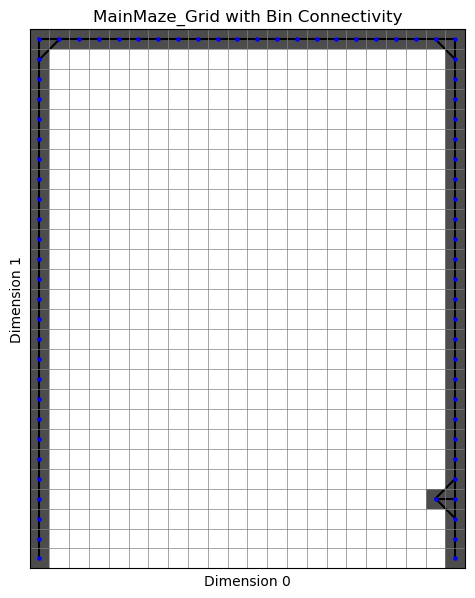

In [8]:
print(f"\n--- Bin & Connectivity Properties for {grid_env_main.name} ---")
# Size of bins (area for 2D, length for 1D)
print(f"Size (area) of the first 5 active bins: {grid_env_main.bin_sizes[:5]} cm^2")

# Active mask: a boolean array showing active bins on the original *full* grid concept
print(
    f"Shape of the active_mask (for the full conceptual grid): {grid_env_main.active_mask.shape}"
)
print(f"Number of True values in active_mask: {np.sum(grid_env_main.active_mask)}")

# Boundary bins: active bins at the "edge" of the environment
print(f"First 10 boundary bin indices: {grid_env_main.boundary_bins[:10]}")

# Neighbors of a bin
if bin_idx != -1 and bin_idx < grid_env_main.n_bins:  # Ensure bin_idx is valid
    neighbors_of_bin = grid_env_main.neighbors(bin_idx)
    print(f"Neighbors of bin {bin_idx}: {neighbors_of_bin}")

    # Geodesic distance (shortest path along the graph)
    if len(neighbors_of_bin) > 0:
        # Distance between bin_idx and its first neighbor
        dist_to_neighbor = grid_env_main.distance_between(
            grid_env_main.bin_center_of(bin_idx),
            grid_env_main.bin_center_of(neighbors_of_bin[0]),
        )
        print(
            f"Geodesic distance between bin {bin_idx} and neighbor {neighbors_of_bin[0]}: {dist_to_neighbor:.2f} cm"
        )

        # Shortest path (sequence of bin indices)
        target_bin_idx_for_path = grid_env_main.boundary_bins[0]  # Example target
        if bin_idx != target_bin_idx_for_path:
            path = grid_env_main.shortest_path(bin_idx, target_bin_idx_for_path)
            print(
                f"Shortest path from bin {bin_idx} to {target_bin_idx_for_path}: {path[:5]}... (first 5 steps)"
            )

# Plot with connectivity
plt.figure(figsize=(6, 6))
ax_conn = grid_env_main.plot(
    show_connectivity=True,
    node_size=5,  # Smaller nodes for bin centers
)
ax_conn.set_title(f"{grid_env_main.name} with Bin Connectivity")
plt.show()

There are also some convenient properties for accessing the `connectivity` graph of the environment:
- **`connectivity`**: The connectivity graph of the environment.
- **`bin_attributes`**: Attributes of the bins (which are nodes in the connectivity graph).
- **`edge_attributes`**: Attributes of the edges in the connectivity graph, useful for understanding the connections between bins.

In [9]:
grid_env_main.bin_attributes

,source_grid_flat_index,original_grid_nd_index,pos_dim0,pos_dim1
active_bin_id,,,,
0,0,"(0, 0)",9.309429,9.864678
1,1,"(0, 1)",9.309429,12.815587
2,2,"(0, 2)",9.309429,15.766496
3,3,"(0, 3)",9.309429,18.717405
4,4,"(0, 4)",9.309429,21.668314
...,...,...,...,...
70,589,"(21, 22)",70.780872,74.784673
71,590,"(21, 23)",70.780872,77.735582
72,591,"(21, 24)",70.780872,80.686491


In [10]:
grid_env_main.edge_attributes

,,distance,vector,angle_2d,edge_id
source_bin,target_bin,,,,
0,1,2.950909,"(0.0, 2.950908858389653)",1.570796,0
1,2,2.950909,"(0.0, 2.950908858389653)",1.570796,1
2,3,2.950909,"(0.0, 2.950908858389653)",1.570796,2
3,4,2.950909,"(0.0, 2.950908858389653)",1.570796,3
4,5,2.950909,"(0.0, 2.950908858389653)",1.570796,4
...,...,...,...,...,...
69,70,2.950909,"(0.0, 2.950908858389653)",1.570796,73
70,71,2.950909,"(0.0, 2.950908858389653)",1.570796,74
71,72,2.950909,"(0.0, 2.950908858389653)",1.570796,75


 ### 2.3 Alternative Layouts, Part 1: Hexagonal Grid
Discretizing space can be done in various ways. The most common is a square grid, but there are alternatives that can better suit specific environments or analysis needs.

Hexagonal grids are useful for open fields or environments where orientation bias of square bins is a concern.
Let's create a hexagonal layout from the same position data.


--- Hexagonal Environment (OpenField_HexEnv) ---
Number of active bins: 60
Spatial extent (dimension_ranges): [(9.34582324737036, 70.74447729413268), (9.88922378357249, 86.56376296009313)]


Text(0, 0.5, 'Y (cm)')

<Figure size 600x600 with 0 Axes>

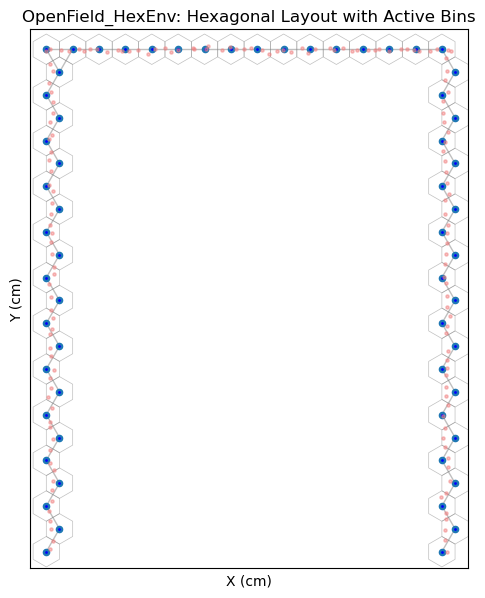

In [11]:
hex_env = Environment.from_layout(
    kind="Hexagonal",
    layout_params={
        "data_samples": position_data_cm,
        "hexagon_width": 4.0,  # Defines the width of hexagons (distance between parallel sides)
        "infer_active_bins": True,
        "bin_count_threshold": 1,  # Bins with at least 1 sample are active
    },
    name="OpenField_HexEnv",
)

print(f"\n--- Hexagonal Environment ({hex_env.name}) ---")
print(f"Number of active bins: {hex_env.n_bins}")
print(f"Spatial extent (dimension_ranges): {hex_env.dimension_ranges}")
# Plot the hexagonal environment
plt.figure(figsize=(6, 6))
ax_hex = hex_env.plot(show_connectivity=True, cmap="Blues")
ax_hex.scatter(
    position_data_cm[:, 0],
    position_data_cm[:, 1],
    **RAW_DATA_STYLE,
    zorder=5,
)
ax_hex.set_title(f"{hex_env.name}: Hexagonal Layout with Active Bins")
plt.xlabel("X (cm)")
plt.ylabel("Y (cm)")

 ## Part 3: Defining and Using Maze-Relevant Regions
There are often specific regions in a maze that are of interest for analysis or decoding. For example, we might want to define the arms of a U-shaped maze, the choice point, and the reward wells.
To facilitate this, we can define regions within our environment. These regions can be used to segment the environment into meaningful parts, allowing for targeted analysis.

Regions can be defined using various methods, such as:
- **`Polygon`**: Define regions using polygons, which can be useful for complex shapes (e.g arms of a maze).
- **`Point`**: Define regions using points, which can be useful for specific locations (e.g. reward wells, choice points).

Polygon regions can be defined using the shapely library, which allows for complex shapes and boundaries.
Specifically the `Polygon` class from the `shapely.geometry` module can be used to define regions based on vertices.

For points, we can just use numpy arrays or lists of coordinates or the Shapely `Point` class.

Let's define some regions for our U-shaped maze:


In [12]:
# First, define all of our point‐ and polygon‐based regions on grid_env_main.
# -----------------------------------------------------------------------------------

xmin, ymin = grid_env_main.dimension_ranges[0][0], grid_env_main.dimension_ranges[1][0]
xmax, ymax = grid_env_main.dimension_ranges[0][1], grid_env_main.dimension_ranges[1][1]
print(
    f"  Bin-centers span X ∈ [{xmin:.1f} … {xmax:.1f}],  Y ∈ [{ymin:.1f} … {ymax:.1f}]."
)

arm_width = 8.0  # e.g. 8 cm total across (so each 3 cm bin × ~2–3 cells)
center_size = 10.0  # a 10×10 cm center square

top_arm_poly = Polygon(
    [
        (xmin, ymax - arm_width),
        (xmax, ymax - arm_width),
        (xmax, ymax),
        (xmin, ymax),
    ]
)

left_arm_poly = Polygon(
    [
        (xmin, ymin),
        (xmin + arm_width, ymin),
        (xmin + arm_width, ymax),
        (xmin, ymax),
    ]
)

right_arm_poly = Polygon(
    [
        (xmax - arm_width, ymin),
        (xmax, ymin),
        (xmax, ymax),
        (xmax - arm_width, ymax),
    ]
)

# Four wells at the four “corners” of the plus‐maze:
well_A = ShapelyPoint(xmin + 2.0, ymin + 2.0)  # near bottom‐left
well_B = ShapelyPoint(xmax - 2.0, ymin + 2.0)  # near bottom‐right
well_C = ShapelyPoint(xmax - 2.0, ymax - 2.0)  # near top‐right
well_D = ShapelyPoint(xmin + 2.0, ymax - 2.0)  # near top‐left


  Bin-centers span X ∈ [7.8 … 72.2],  Y ∈ [8.4 … 88.1].


Now let's add them to our environment. Regions are stored as as an attributes of the environment and can be accessed via the `regions` property.

For example, here we use `grid_env_main.regions` to access the regions defined in the main grid environment.

In order to add regions to the environment, we can use `regions.add()` method, which takes a single region as an argument.

We can use `regions.list_names()` to get a list of all region names in the environment.

In [13]:
# 5) Clear out the old regions, then add the new ones:
grid_env_main.regions.clear()
grid_env_main.regions.add(
    name="RightArm",
    polygon=right_arm_poly,
    metadata={"plot_kwargs": {"facecolor": "mediumseagreen"}},
)
grid_env_main.regions.add(
    name="TopArm",
    polygon=top_arm_poly,
    metadata={"plot_kwargs": {"facecolor": "deepskyblue"}},
)
grid_env_main.regions.add(
    name="LeftArm",
    polygon=left_arm_poly,
    metadata={"plot_kwargs": {"facecolor": "mediumpurple"}},
)

grid_env_main.regions.add(
    name="Well_A", point=well_A, metadata={"plot_kwargs": {"color": "red"}}
)
grid_env_main.regions.add(
    name="Well_B", point=well_B, metadata={"plot_kwargs": {"color": "blue"}}
)
grid_env_main.regions.add(
    name="Well_C", point=well_C, metadata={"plot_kwargs": {"color": "green"}}
)
grid_env_main.regions.add(
    name="Well_D", point=well_D, metadata={"plot_kwargs": {"color": "magenta"}}
)

print(f"Defined regions: {grid_env_main.regions.list_names()}")

Defined regions: ['RightArm', 'TopArm', 'LeftArm', 'Well_A', 'Well_B', 'Well_C', 'Well_D']


Now we can visualize the environment with the defined regions. The `plot()` method will show the bins and highlight the regions we've defined if we set `show_regions=True` in the `plot()` method.

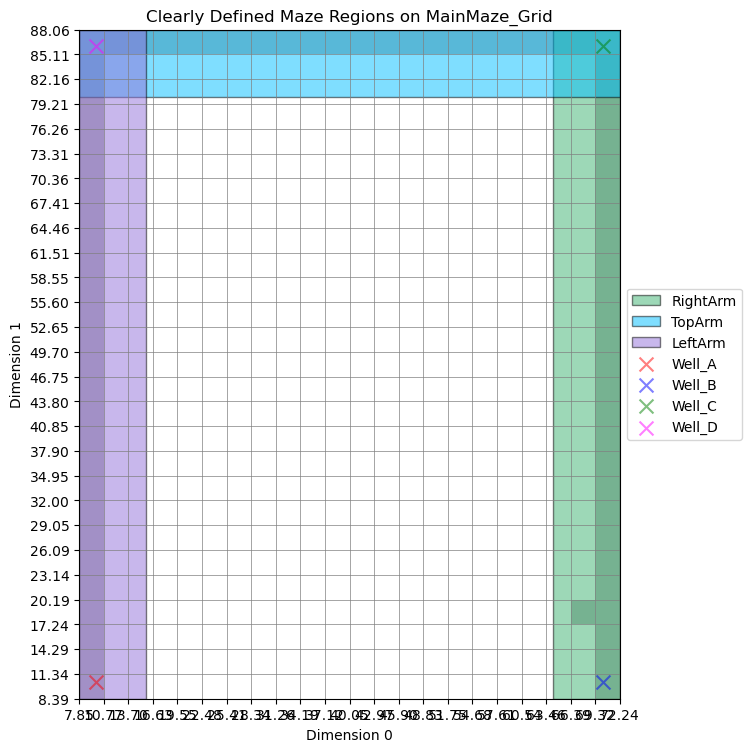

In [14]:
# -----------------------------------------------------------------------------------
# Now plot everything in one figure.
# -----------------------------------------------------------------------------------
fig_regions_adv, ax_regions_adv = plt.subplots(figsize=(8, 8))

# 1) Start by drawing the grid itself (very faint), so regions float on top.
grid_env_main.plot(ax=ax_regions_adv, show_connectivity=False, alpha=0.3, cmap="Greys", show_regions=True)
ax_regions_adv.set_title(f"Clearly Defined Maze Regions on {grid_env_main.name}")
ax_regions_adv.set_aspect("equal", "box")
plt.tight_layout(rect=[0, 0, 0.8, 1])
plt.show()

We can also visualize the regions separately using the `plot_regions()` method, which will show only the regions without the bins.

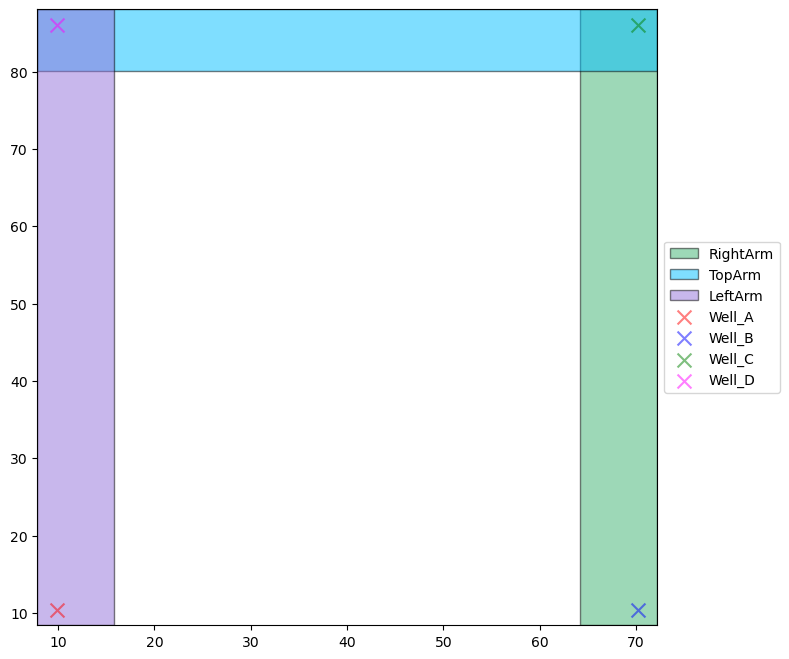

In [15]:
fig, ax = plt.subplots(figsize=(8, 8))
plot_regions(
    ax=ax,
    regions=grid_env_main.regions,
)

 ### 3.1 Summarizing Data Per Region
 This is where regions become powerful. Let's say we have neural data (e.g., average firing rate
 of a cell, or the posterior probability from a decoder) for each bin in our environment.

 We can use the method `mask_for_region(region_name)` to get a boolean mask for a specific region.
This mask can then be used to summarize data across the bins in that region.




--- Summarizing Mock Data per Region for MainMaze_Grid ---
Region 'RightArm': 30 bins, Mean Value = 7.00, Sum Value = 209.85, Max Value = 9.14
Region 'TopArm': 26 bins, Mean Value = 7.08, Sum Value = 184.02, Max Value = 9.03
Region 'LeftArm': 29 bins, Mean Value = 4.14, Sum Value = 120.17, Max Value = 6.58
Region 'Well_A': 1 bins, Mean Value = 1.19, Sum Value = 1.19, Max Value = 1.19
Region 'Well_B': 1 bins, Mean Value = 5.92, Sum Value = 5.92, Max Value = 5.92
Region 'Well_C': 1 bins, Mean Value = 8.14, Sum Value = 8.14, Max Value = 8.14
Region 'Well_D': 1 bins, Mean Value = 5.27, Sum Value = 5.27, Max Value = 5.27


<Figure size 700x600 with 0 Axes>

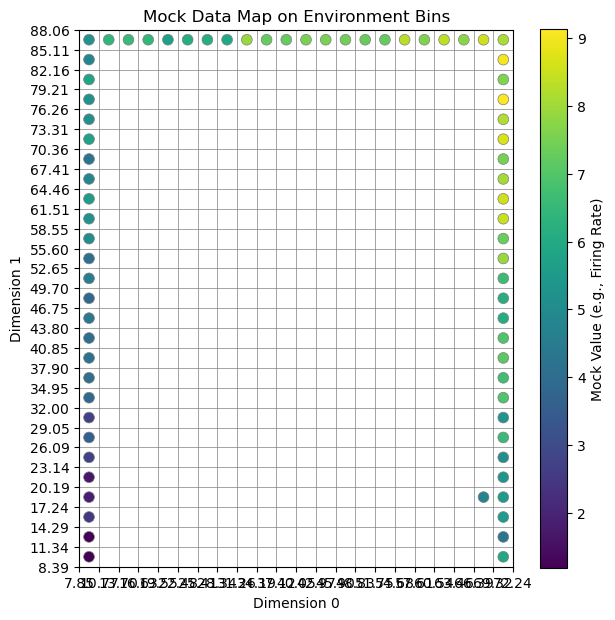

In [16]:
# Create mock data: e.g., a "firing rate map" or "decoded probability map"
# Higher values towards one corner for this example
mock_data_per_bin = np.zeros(grid_env_main.n_bins)

for i in range(grid_env_main.n_bins):
    x, y = grid_env_main.bin_centers[i]
    mock_data_per_bin[i] = (x + y) / 20  # Simple gradient for illustration
mock_data_per_bin = np.clip(
    mock_data_per_bin + np.random.rand(grid_env_main.n_bins) * 2, 0, None
)

print(f"\n--- Summarizing Mock Data per Region for {grid_env_main.name} ---")
summary_stats = {}
for region_name in grid_env_main.regions.list_names():
    # Creat a mask for the current region
    # This is a boolean array where True means the bin is in this region
    region_mask = grid_env_main.mask_for_region(region_name)
    data_in_region = mock_data_per_bin[region_mask]

    if data_in_region.size > 0:
        mean_val = np.mean(data_in_region)
        sum_val = np.sum(data_in_region)
        max_val = np.max(data_in_region)
        summary_stats[region_name] = {
            "mean": mean_val,
            "sum": sum_val,
            "max": max_val,
            "n_bins": data_in_region.size,
        }
        print(
            f"Region '{region_name}': {data_in_region.size} bins, "
            f"Mean Value = {mean_val:.2f}, Sum Value = {sum_val:.2f}, Max Value = {max_val:.2f}"
        )
    else:
        summary_stats[region_name] = {
            "mean": np.nan,
            "sum": 0,
            "max": np.nan,
            "n_bins": 0,
        }
        print(f"Region '{region_name}': No active bins found, or no data in bins.")

# Visualizing the mock data map
plt.figure(figsize=(7, 6))
ax_data_map = grid_env_main.plot(show_connectivity=False, alpha=0.0)  # No grid fill
sc_data = ax_data_map.scatter(
    grid_env_main.bin_centers[:, 0],
    grid_env_main.bin_centers[:, 1],
    c=mock_data_per_bin,
    cmap="viridis",
    s=60,
    edgecolor="gray",
    linewidth=0.5,
)
plt.colorbar(sc_data, ax=ax_data_map, label="Mock Value (e.g., Firing Rate)")
ax_data_map.set_title("Mock Data Map on Environment Bins")
plt.show()

 ## Part 4: Diverse Ways to Define Environment Geometries
 While `from_samples` is common an easy way to create an environment, you might want to define the valid space of the environment in other ways.

Some alternatives include:
- **Using `Graph`**: If you have  a track with linear segments or an abstract 1D space (like head direction), you can define a graph to parameterize the space.
- **Using `Polygon`** and **`TriangularMesh`**: For complex boundaries, you might want to define the environment using polygons. This is useful for irregularly shaped mazes or areas.
- **Using `MaskedGrid`**: If you have a grid layout but want to mask out certain areas (e.g., walls or inaccessible regions), you can use a masked grid layout.
- **Using `Hexagonal`**: For environments where hexagonal bins are more appropriate, you can define a hexagonal layout.
- **Using `ImageMask`**: If you have an image of the maze, you can create a layout based on the image mask, which allows you to define the environment based on the maze's visual representation.


 ### 4.1 From an Image Mask (e.g., from a maze schematic)


--- Environment from ImageMask (TMaze_FromImage) ---
Number of active bins: 152


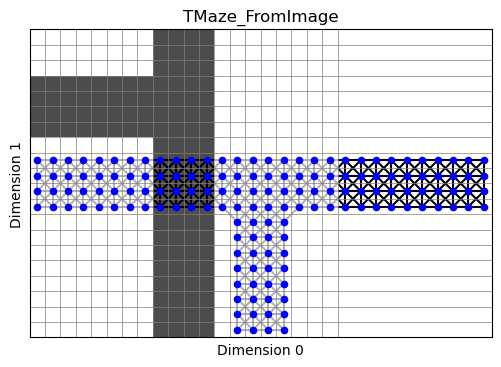

In [17]:
# Create a simple 2D numpy array as a boolean mask
# True means 'part of the maze', False means 'wall' or 'outside'
# Let's make a simple T-maze shape
image_maze_mask = np.zeros((20, 30), dtype=bool)
image_maze_mask[8:12, :] = True  # Horizontal stem
image_maze_mask[:10, 13:17] = True  # Vertical arm

env_from_image = Environment.from_image(
    image_mask=image_maze_mask,
    bin_size=2.0,  # Each "pixel" in the mask corresponds to a 2x2 cm bin
    name="TMaze_FromImage",
)
print(f"\n--- Environment from ImageMask ({env_from_image.name}) ---")
print(f"Number of active bins: {env_from_image.n_bins}")

plt.figure(figsize=(6, 4))
env_from_image.plot(ax=plt.gca())  # gca() gets current axes
plt.title(f"{env_from_image.name}")
plt.show()

 ### 4.2 Graph-Based Environments (for linear tracks, 1D variables)
 Ideal for mazes with clear linear segments (T-maze arms, linear tracks) or even abstract 1D variables like head direction.


--- Graph-Based Environment (TMaze_Graph) ---
Is it 1D? True
Number of bins: 32


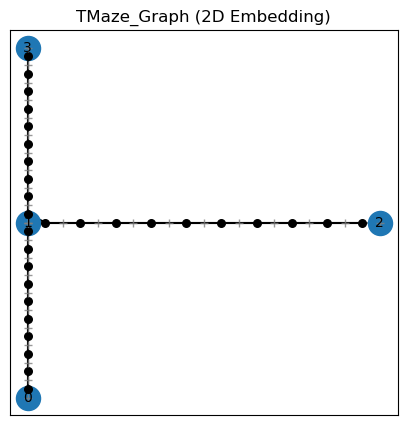

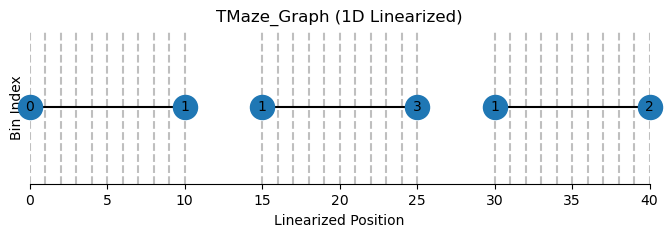

Point [ 0. 15.] on T-maze -> Linear coord: 20.00
Linear coord 20.00 -> N-D coord: [ 0. 15.]


In [18]:
# Define a T-maze graph structure
# Node positions in cm (approximate)
#      (0,20) Node3 (Top of T)
#        |
#      (0,10) Node1 (Junction) -- (10,10) Node2 (Right end)
#        |
#      (0,0)  Node0 (Stem base)

tmaze_nodes = [(0, 0), (0, 10), (10, 10), (0, 20)]
tmaze_edges = [
    (0, 1),
    (1, 2),
    (1, 3),
]  # Stem, Right arm, Left arm (relative to junction)
tmaze_graph_def = make_track_graph(tmaze_nodes, tmaze_edges)

# For a Graph environment, `edge_order` is crucial for linearization
tmaze_edge_order = [
    (0, 1),
    (1, 3),
    (1, 2),
]  # Stem -> Left Arm -> Right Arm (example order)

env_tmaze_graph = Environment.from_graph(
    graph=tmaze_graph_def,
    edge_order=tmaze_edge_order,
    edge_spacing=5.0,  # Small gap between linearized segments for clarity
    bin_size=1.0,  # Each bin along the graph is 1cm long
    name="TMaze_Graph",
)

print(f"\n--- Graph-Based Environment ({env_tmaze_graph.name}) ---")
print(f"Is it 1D? {env_tmaze_graph.is_1d}")  # True
print(f"Number of bins: {env_tmaze_graph.n_bins}")

# Plot its N-D embedding
fig_tgraph, ax_tgraph = plt.subplots(figsize=(5, 5))
env_tmaze_graph.plot(ax=ax_tgraph, bin_node_kwargs={"node_size": 20})
ax_tgraph.set_title(f"{env_tmaze_graph.name} (2D Embedding)")
plt.show()

# Plot its 1D linearized representation
fig_tgraph_1d, ax_tgraph_1d = plt.subplots(figsize=(8, 2))
env_tmaze_graph.plot_1D(ax=ax_tgraph_1d)  # Specific method for 1D graph plots
ax_tgraph_1d.set_title(f"{env_tmaze_graph.name} (1D Linearized)")
plt.show()

# Using to_linear and linear_to_nd
if env_tmaze_graph.n_bins > 0:
    example_nd_point_on_tmaze = np.array([[0, 15.0]])  # On the N arm of T
    linear_coord = env_tmaze_graph.to_linear(example_nd_point_on_tmaze)
    print(
        f"Point {example_nd_point_on_tmaze[0]} on T-maze -> Linear coord: {linear_coord[0]:.2f}"
    )
    reproj_nd_point = env_tmaze_graph.linear_to_nd(linear_coord)
    print(f"Linear coord {linear_coord[0]:.2f} -> N-D coord: {reproj_nd_point[0]}")

 *Aside: Abstract Variables*: A `GraphLayout` could represent a circular variable like head direction (0-360°). The 'nodes' would be angles, 'pos' attributes could be `(cos(angle), sin(angle))` for embedding on a circle, and `bin_size` would be in degrees.

 ### 4.3 Complex Boundaries: `Polygon` and `TriangularMesh`
 For mazes with arbitrary shapes, like a circular arena or a custom-designed open field.


--- Polygon-Defined Environment (CircularArena_Polygon) ---
Number of bins: 225


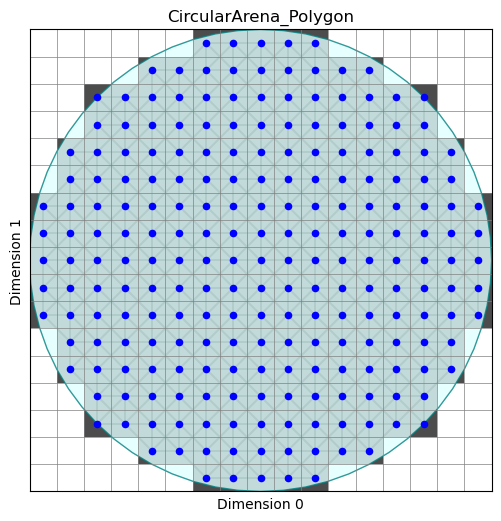

In [19]:
# Circular Arena defined by a Polygon
# Shapely can approximate a circle with a buffered point
arena_center = ShapelyPoint(0.0, 0.0)
arena_radius = 25.0  # cm
circular_arena_poly = arena_center.buffer(
    arena_radius
)  # Creates a polygonal approximation of a circle

env_circle_poly = Environment.from_polygon(
    polygon=circular_arena_poly,
    bin_size=3.0,  # Bins inside the circle
    name="CircularArena_Polygon",
)
print(f"\n--- Polygon-Defined Environment ({env_circle_poly.name}) ---")
print(f"Number of bins: {env_circle_poly.n_bins}")

fig_poly, ax_poly = plt.subplots(figsize=(6, 6))
env_circle_poly.plot(
    ax=ax_poly, polygon_kwargs={"fc": "lightcyan", "ec": "teal", "alpha": 0.8}
)
ax_poly.set_title(f"{env_circle_poly.name}")
plt.show()

 For even more complex, organic boundaries, you could use a `hexagonal layout` or a `triangular mesh`.
 These both avoid the orientation bias of square bins and can adapt to irregular shapes.
 Triangular meshes can be defined by a boundary polygon and a point spacing.


--- TriangularMesh Environment (Circular_TriMesh) ---
Number of bins (triangles): 498


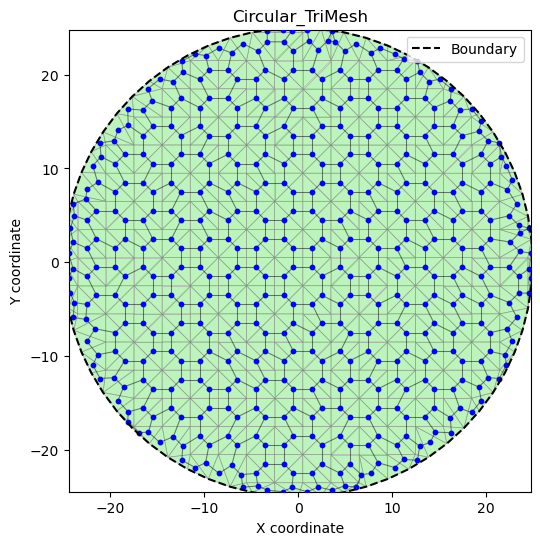

In [20]:
env_tri_mesh = Environment.from_layout(
    kind="TriangularMesh",
    layout_params={
        "boundary_polygon": circular_arena_poly,
        "point_spacing": 3.0,  # Controls density of mesh vertices
    },
    name="Circular_TriMesh",
)
print(f"\n--- TriangularMesh Environment ({env_tri_mesh.name}) ---")
print(f"Number of bins (triangles): {env_tri_mesh.n_bins}")

fig_mesh, ax_mesh = plt.subplots(figsize=(6, 6))
env_tri_mesh.plot(ax=ax_mesh, triangle_kwargs={"fc": "lightgreen", "alpha": 0.6})
ax_mesh.set_title(f"{env_tri_mesh.name}")
plt.show()

 ### 4.4 Other Layouts (`HexagonalLayout`, `MaskedGridLayout`)
 `HexagonalLayout` is also useful for open fields to reduce orientation bias of square bins.
 `MaskedGridLayout` is great when you have explicit grid lines and a precise boolean mask of active cells.

 ## Part 5: Working with Multiple Environments 🤝

 ### 5.1 `CompositeEnvironment`: Modeling Complex Mazes with Distinct Parts
 Some mazes have sections best modeled differently (e.g., an open central area connected to linear arms).
 Let's build a plus-maze: a square center (`RegularGrid`) and four linear arms (`GraphLayout`).


--- Advanced Composite Environment (Plus Maze) ---
Plus Maze Composite Environment: 76 total bins.


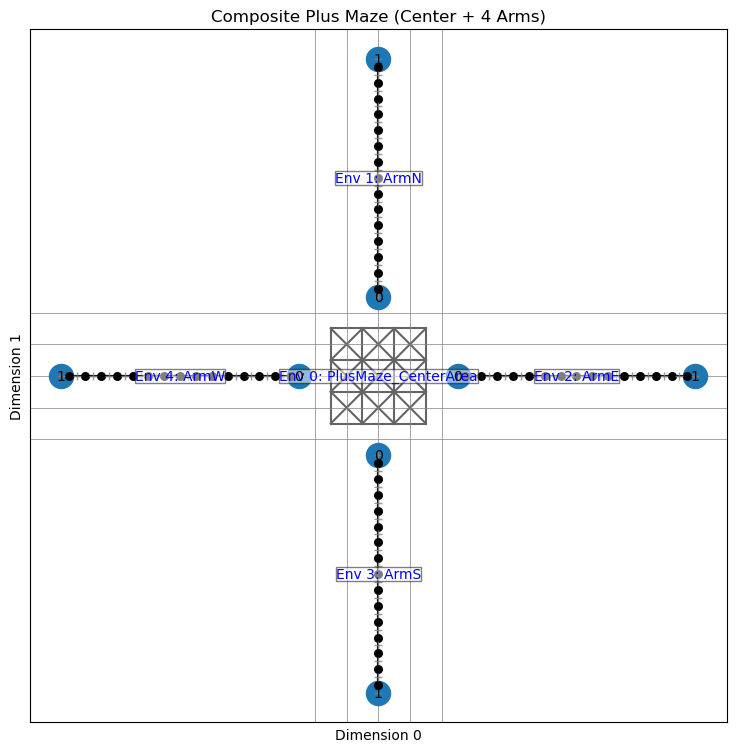

Distance from North arm end to East arm end in Plus Maze: 28.00 cm


In [21]:
print("\n--- Advanced Composite Environment (Plus Maze) ---")

# Central Area (e.g., 20x20 cm, centered at (0,0))
# Use a simple RegularGrid for the center, defining its extent with `dimension_ranges`.
# so that the grid covers a perfect 16×16 cm block at center.
# Then each arm attaches seamlessly at ±8 cm.
env_center_plusmaze = Environment.from_layout(
    kind="RegularGrid",
    layout_params={
        "bin_size": 4.0,  # Coarser bins for center
        "dimension_ranges": [[-8, 8], [-8, 8]],  # Center area extent
    },
    name="PlusMaze_CenterArea",
)

# Arms (each 30cm long, 2cm wide conceptually for plotting, binned at 2cm)
arm_len = 30.0
arm_bs = 2.0

# Define nodes relative to the center area's presumed edges
# Center area estimated extent based on samples and binning: roughly -10 to 10.
# So, arms connect around +/-10.
env_arm_N = Environment.from_graph(
    make_track_graph([(0, 10), (0, 10 + arm_len)], [(0, 1)]),
    [(0, 1)],
    0,
    arm_bs,
    "ArmN",
)
env_arm_E = Environment.from_graph(
    make_track_graph([(10, 0), (10 + arm_len, 0)], [(0, 1)]),
    [(0, 1)],
    0,
    arm_bs,
    "ArmE",
)
env_arm_S = Environment.from_graph(
    make_track_graph([(0, -10), (0, -10 - arm_len)], [(0, 1)]),
    [(0, 1)],
    0,
    arm_bs,
    "ArmS",
)
env_arm_W = Environment.from_graph(
    make_track_graph([(-10, 0), (-10 - arm_len, 0)], [(0, 1)]),
    [(0, 1)],
    0,
    arm_bs,
    "ArmW",
)

plus_maze_parts = [env_center_plusmaze, env_arm_N, env_arm_E, env_arm_S, env_arm_W]
plus_maze_parts_valid = [env for env in plus_maze_parts if env.n_bins > 0]

if len(plus_maze_parts_valid) > 1:
    env_plus_maze = CompositeEnvironment(
        plus_maze_parts_valid,
        auto_bridge=True,
        max_mnn_distance=5.0,  # Allow bridges if ends are within 5cm
    )
    print(f"Plus Maze Composite Environment: {env_plus_maze.n_bins} total bins.")

    fig_plus, ax_plus = plt.subplots(figsize=(9, 9))
    # Customize plotting for each sub-environment
    plot_kwargs_list = [
        {"cmap": "Greys", "alpha": 0.4, "node_size": 0},  # Center
        {
            "bin_node_kwargs": {"color": "blue", "node_size": 15},
            "edge_kwargs": {"alpha": 0.6},
        },  # N
        {
            "bin_node_kwargs": {"color": "green", "node_size": 15},
            "edge_kwargs": {"alpha": 0.6},
        },  # E
        {
            "bin_node_kwargs": {"color": "purple", "node_size": 15},
            "edge_kwargs": {"alpha": 0.6},
        },  # S
        {
            "bin_node_kwargs": {"color": "orange", "node_size": 15},
            "edge_kwargs": {"alpha": 0.6},
        },  # W
    ]
    env_plus_maze.plot(
        ax=ax_plus,
        show_sub_env_labels=True,
        sub_env_plot_kwargs=plot_kwargs_list[: len(plus_maze_parts_valid)],
        bridge_edge_kwargs={"color": "red", "linewidth": 1.5, "linestyle": "--"},
    )
    ax_plus.set_title("Composite Plus Maze (Center + 4 Arms)")
    ax_plus.axis("equal")
    plt.show()

    # Test distance across bridges
    # Point in North arm end vs. East arm end
    pt_N_end = np.array(
        [[0, 10 + arm_len - arm_bs / 2]]
    )  # Slightly inside last bin of N arm
    pt_E_end = np.array(
        [[10 + arm_len - arm_bs / 2, 0]]
    )  # Slightly inside last bin of E arm
    dist_N_E_plusmaze = env_plus_maze.distance_between(pt_N_end, pt_E_end)
    print(
        f"Distance from North arm end to East arm end in Plus Maze: {dist_N_E_plusmaze:.2f} cm"
    )
else:
    print(
        "Skipping composite plus maze demo as not enough valid sub-environments were created."
    )

 ### 5.2 `Alignment`: Comparing Data Across Sessions with Environmental Changes
 Often, the maze setup might slightly change between recording sessions (shift, rotation, minor scaling).
 `map_probabilities_to_nearest_target_bin` helps compare data (e.g., place fields) across such sessions.


--- Environment Alignment Demo ---
Sum of original probabilities (S1): 1.000
Sum of mapped probabilities (S2): 1.000


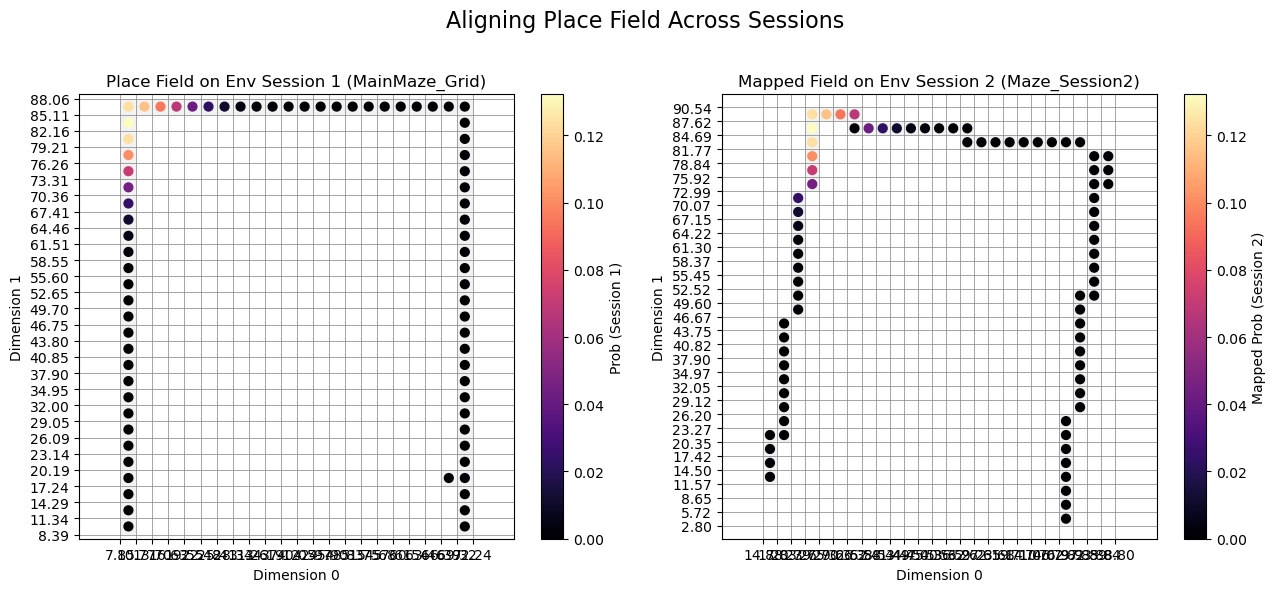

In [22]:
print("\n--- Environment Alignment Demo ---")
# Use our main grid environment as the 'source' (Session 1)
if grid_env_main is not None and grid_env_main.n_bins > 0:
    env_session1 = grid_env_main

    # Simulate data for Session 2: shift, rotate, and slightly scale Session 1's positions
    s1_to_s2_shift = np.array([5.0, 3.0])  # Shift by (5cm, 3cm)
    s1_to_s2_angle_deg = -7.0  # Rotate clockwise by 7 degrees
    s1_to_s2_scale = 1.02  # Slightly larger

    s1_to_s2_rot_matrix = get_2d_rotation_matrix(s1_to_s2_angle_deg)

    # Need original position_data_cm that defined grid_env_main (env_session1)
    if "position_data_cm" in locals():
        positions_session2 = apply_similarity_transform(
            position_data_cm, s1_to_s2_rot_matrix, s1_to_s2_scale, s1_to_s2_shift
        )
        env_session2 = Environment.from_samples(
            data_samples=positions_session2,
            bin_size=grid_env_main.layout_parameters.get(
                "bin_size", 3.0
            ),  # Use same bin_size
            name="Maze_Session2",
        )

        if env_session1.n_bins > 0 and env_session2.n_bins > 0:
            # Create a hypothetical "place field" (probability distribution) on Session 1 env
            field_center_s1_idx = env_session1.n_bins // 3  # Arbitrary center
            field_center_s1_coords = env_session1.bin_center_of(field_center_s1_idx)

            sq_dists_s1 = np.sum(
                (env_session1.bin_centers - field_center_s1_coords) ** 2, axis=1
            )
            probs_s1 = np.exp(
                -sq_dists_s1 / (2 * (8.0**2))
            )  # Gaussian field, sigma=8cm
            probs_s1 = probs_s1 / np.sum(probs_s1) if np.sum(probs_s1) > 0 else probs_s1

            # Map this field from Session 1 coordinates to Session 2 environment
            # The transform params are those that take Session 1 points TO Session 2 space
            mapped_probs_s2 = map_probabilities_to_nearest_target_bin(
                source_env=env_session1,
                target_env=env_session2,
                source_probs=probs_s1,
                source_rotation_matrix=s1_to_s2_rot_matrix,
                source_scale_factor=s1_to_s2_scale,
                source_translation_vector=s1_to_s2_shift,
            )
            print(f"Sum of original probabilities (S1): {np.sum(probs_s1):.3f}")
            print(
                f"Sum of mapped probabilities (S2): {np.sum(mapped_probs_s2):.3f}"
            )  # Should be close to S1

            # Plot
            fig_align_sess, (ax_s1, ax_s2) = plt.subplots(1, 2, figsize=(13, 6))
            common_cbar_args = {
                "cmap": "magma",
                "vmin": 0,
                "vmax": (
                    np.max([probs_s1.max(), mapped_probs_s2.max()])
                    if mapped_probs_s2.size > 0
                    else probs_s1.max()
                ),
            }

            env_session1.plot(ax=ax_s1, show_connectivity=False, alpha=0.05)
            sc1 = ax_s1.scatter(
                env_session1.bin_centers[:, 0],
                env_session1.bin_centers[:, 1],
                c=probs_s1,
                s=40,
                **common_cbar_args,
            )
            plt.colorbar(sc1, ax=ax_s1, label="Prob (Session 1)")
            ax_s1.set_title(f"Place Field on Env Session 1 ({env_session1.name})")
            ax_s1.axis("equal")

            env_session2.plot(ax=ax_s2, show_connectivity=False, alpha=0.05)
            if env_session2.n_bins > 0 and mapped_probs_s2.size == env_session2.n_bins:
                sc2 = ax_s2.scatter(
                    env_session2.bin_centers[:, 0],
                    env_session2.bin_centers[:, 1],
                    c=mapped_probs_s2,
                    s=40,
                    **common_cbar_args,
                )
                plt.colorbar(sc2, ax=ax_s2, label="Mapped Prob (Session 2)")
            ax_s2.set_title(f"Mapped Field on Env Session 2 ({env_session2.name})")
            ax_s2.axis("equal")

            plt.suptitle("Aligning Place Field Across Sessions", fontsize=16)
            plt.tight_layout(rect=[0, 0, 1, 0.96])
            plt.show()
        else:
            print(
                "Skipping session alignment demo as one of the environments has no bins."
            )
    else:
        print("Skipping session alignment demo: 'position_data_cm' not found.")
else:
    print(
        "Skipping session alignment demo: 'grid_env_main' not available or has no bins."
    )

 ## Part 6: Discovering Available Layouts 🔍
 You can easily list all built-in layout types and their required parameters.

In [23]:
import inspect  # Needed for pretty printing default values

print("\n--- API Discovery: Available Layouts and Parameters ---")
available_layout_types = list_available_layouts()
print("Available layout kinds (case-insensitive):\n", available_layout_types)

for layout_name in available_layout_types:
    print(f"\nParameters for '{layout_name}':")
    try:
        params = get_layout_parameters(layout_name)
        if not params:
            print(f"  (No specific build parameters listed for {layout_name})")
        for param_name, info in params.items():
            p_type = info.get("annotation", "Any")
            p_default = info.get("default")
            default_str = (
                f"(default: {repr(p_default)})"
                if p_default is not inspect.Parameter.empty
                else "(required)"
            )
            print(f"  - {param_name}: (type: {p_type}, {default_str})")
    except Exception as e:  # Catch any error during introspection
        print(f"  Could not retrieve parameters for {layout_name}: {e}")


--- API Discovery: Available Layouts and Parameters ---
Available layout kinds (case-insensitive):
 ['Graph', 'Hexagonal', 'ImageMask', 'MaskedGrid', 'RegularGrid', 'ShapelyPolygon', 'TriangularMesh']

Parameters for 'Graph':
  - graph_definition: (type: <class 'networkx.classes.graph.Graph'>, (default: None))
  - edge_order: (type: typing.List[typing.Tuple[typing.Any, typing.Any]], (default: None))
  - edge_spacing: (type: typing.Union[float, typing.Sequence[float]], (default: None))
  - bin_size: (type: <class 'float'>, (default: None))

Parameters for 'Hexagonal':
  - hexagon_width: (type: <class 'float'>, (default: None))
  - dimension_ranges: (type: typing.Optional[typing.Tuple[typing.Tuple[float, float], typing.Tuple[float, float]]], (default: None))
  - data_samples: (type: typing.Optional[numpy.ndarray[typing.Any, numpy.dtype[numpy.float64]]], (default: None))
  - infer_active_bins: (type: <class 'bool'>, (default: True))
  - bin_count_threshold: (type: <class 'int'>, (default

 ## Part 7: Saving and Loading Environments 💾
 Once you've configured an environment (which can involve computationally intensive steps like
 inferring active bins from many samples), you'll want to save it for later use.
 The `Environment` object can be easily saved and loaded using Python's `pickle` module.

In [24]:
print("\n--- Saving and Loading Environments ---")
if grid_env_main is not None and grid_env_main.n_bins > 0:
    # Create a temporary file path for this demo
    temp_dir = tempfile.gettempdir()
    env_filepath = os.path.join(temp_dir, "my_main_maze_env.pkl")

    print(f"Attempting to save environment '{grid_env_main.name}' to: {env_filepath}")
    grid_env_main.save(env_filepath)  # Uses pickle

    # Now, let's load it back
    loaded_env = Environment.load(env_filepath)
    print(f"Successfully loaded environment: {loaded_env.name}")
    print(
        f"Loaded environment has {loaded_env.n_bins} bins and layout type '{loaded_env.layout_type}'."
    )
    print(
        f"Original layout parameters were: {loaded_env.layout_parameters.get('bin_size')} bin_size."
    )

    # Basic check: are the number of bins the same?
    if loaded_env.n_bins == grid_env_main.n_bins:
        print(
            "Loaded environment seems consistent with the saved one (checked n_bins)."
        )
    else:
        print("Warning: Loaded environment n_bins mismatch!")

    # Clean up the temporary file (optional for a real workflow)
    try:
        os.remove(env_filepath)
        print(f"Cleaned up temporary file: {env_filepath}")
    except OSError as e:
        print(f"Error removing temporary file {env_filepath}: {e}")
else:
    print("Skipping Save/Load demo as grid_env_main is not available or has no bins.")


--- Saving and Loading Environments ---
Attempting to save environment 'MainMaze_Grid' to: /var/folders/86/m147b4k17lddvs_xsw0mj2zw0000gn/T/my_main_maze_env.pkl
Environment saved to /var/folders/86/m147b4k17lddvs_xsw0mj2zw0000gn/T/my_main_maze_env.pkl
Successfully loaded environment: MainMaze_Grid
Loaded environment has 75 bins and layout type 'RegularGrid'.
Original layout parameters were: 3.0 bin_size.
Loaded environment seems consistent with the saved one (checked n_bins).
Cleaned up temporary file: /var/folders/86/m147b4k17lddvs_xsw0mj2zw0000gn/T/my_main_maze_env.pkl


 ### Tutorial Complete! 🎉

 You've now journeyed through:
 - Calibrating raw pixel data to physical units.
 - Creating `Environment` objects from various data sources (samples, images, graphs, polygons, meshes).
 - Interacting with these environments: mapping points, finding neighbors, calculating distances.
 - Defining meaningful `Regions` for detailed spatial analysis (e.g., reward wells, maze arms).
 - Modeling complex, multi-part mazes with `CompositeEnvironment`.
 - Aligning and mapping probability distributions (like place fields) across different sessions or environmental setups using the `alignment` tools.
 - Discovering the available layout types and their parameters.
 - Saving and loading environments for future use.

 This `environment` package provides a powerful and flexible toolkit for representing your experimental spaces,
 which is a cornerstone for robust Bayesian decoding and many other types of spatial data analysis
 in hippocampal research. Happy decoding!

Connected to non_local_detector2 (Python 3.12.7)